Loading and processing data for ts100m and bs100m...
Found 18 files with ts100m_bs100m pattern
Processed: 10n_gateway_results_100bs/10n_result_ior_2_ts100m_bs100m_t2/2_ts100m_bs100m_t2.json -> tasks_per_node:2, write:1057.8658, read:1048.7473
Processed: 10n_gateway_results_100bs/10n_result_ior_1_ts100m_bs100m_t2/1_ts100m_bs100m_t2.json -> tasks_per_node:1, write:1042.2464, read:1081.4424
Processed: 10n_gateway_results_100bs/10n_result_ior_8_ts100m_bs100m_t2/8_ts100m_bs100m_t2.json -> tasks_per_node:8, write:1107.4412, read:1094.588
Processed: 10n_gateway_results_100bs/10n_result_ior_8_ts100m_bs100m_t3/8_ts100m_bs100m_t3.json -> tasks_per_node:8, write:1106.7282, read:1102.0718
Processed: 10n_gateway_results_100bs/10n_result_ior_2_ts100m_bs100m_t1/2_ts100m_bs100m_t1.json -> tasks_per_node:2, write:1061.1059, read:1070.9614
Processed: 10n_gateway_results_100bs/10n_result_ior_32_ts100m_bs100m_t1/32_ts100m_bs100m_t1.json -> tasks_per_node:32, write:1117.8202, read:1112.3646
Processed: 10n_

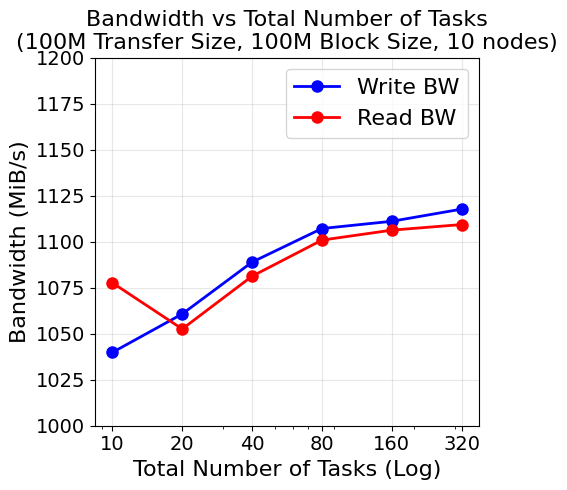


Summary of processed data:
Total Tasks  Tasks/Node Write BW (MiB/s) Read BW (MiB/s)
------------------------------------------------------------
10           1          1039.8          1077.6         
20           2          1060.7          1052.6         
40           4          1088.9          1081.2         
80           8          1107.1          1100.8         
160          16         1111.1          1106.2         
320          32         1117.7          1109.3         

Total tasks range: 10 to 320
Write BW range: 1039.8 to 1117.7 MiB/s
Read BW range: 1052.6 to 1109.3 MiB/s


In [5]:
import os
import json
import matplotlib.pyplot as plt
import re
from collections import defaultdict

# Constants
NUM_NODES = 10

def extract_tasks_per_node(filepath):
    """Extract tasks per node from filepath"""
    # Extract from filename like '32_ts100m_bs100m_t1.json' 
    filename = os.path.basename(filepath)
    
    # Extract the number at the beginning of filename
    match = re.search(r'^(\d+)_ts', filename)
    if match:
        return int(match.group(1))
    
    return None

def load_and_process_data():
    """Load specific JSON files and process the data for ts100m and bs100m"""
    data = defaultdict(list)  # data[tasks_per_node] = [(write_bw, read_bw), ...]
    
    # Search in the specific directory structure
    base_dir = '10n_gateway_results_100bs'
    if not os.path.exists(base_dir):
        print(f"Directory {base_dir} not found in current path")
        return data
    
    # Find all JSON files with ts100m and bs100m pattern
    json_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.json') and 'ts100m_bs100m' in file:
                json_files.append(os.path.join(root, file))
    
    print(f"Found {len(json_files)} files with ts100m_bs100m pattern")
    
    for json_file in json_files:
        tasks_per_node = extract_tasks_per_node(json_file)
        if tasks_per_node is None:
            print(f"Could not extract tasks per node from: {json_file}")
            continue
        
        try:
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                
            if 'summary' not in json_data:
                print(f"No summary found in: {json_file}")
                continue
                
            write_bw = None
            read_bw = None
            
            for entry in json_data['summary']:
                if entry.get('operation') == 'write':
                    write_bw = entry.get('bwMeanMIB')
                elif entry.get('operation') == 'read':
                    read_bw = entry.get('bwMeanMIB')
            
            if write_bw is not None or read_bw is not None:
                data[tasks_per_node].append((write_bw, read_bw))
                print(f"Processed: {json_file} -> tasks_per_node:{tasks_per_node}, write:{write_bw}, read:{read_bw}")
                
        except Exception as e:
            print(f"Error processing {json_file}: {e}")
    
    return data

def average_data(data):
    """Average the bandwidth values for each tasks_per_node configuration"""
    averaged_data = {}
    
    for tasks_per_node, bw_list in data.items():
        write_bws = [bw[0] for bw in bw_list if bw[0] is not None]
        read_bws = [bw[1] for bw in bw_list if bw[1] is not None]
        
        avg_write_bw = sum(write_bws) / len(write_bws) if write_bws else None
        avg_read_bw = sum(read_bws) / len(read_bws) if read_bws else None
        
        if avg_write_bw is not None or avg_read_bw is not None:
            averaged_data[tasks_per_node] = (avg_write_bw, avg_read_bw)
    
    return averaged_data

# Load and process all data
print("Loading and processing data for ts100m and bs100m...")
all_data = load_and_process_data()

print(f"\nFound data for {len(all_data)} different tasks per node configurations:")
for tpn in sorted(all_data.keys()):
    print(f"  Tasks per node: {tpn} (total tasks: {tpn * NUM_NODES})")

# Average the data across trials (t1, t2, t3)
averaged_data = average_data(all_data)

# Prepare data for plotting
plot_data = []
for tasks_per_node, (write_bw, read_bw) in averaged_data.items():
    total_tasks = tasks_per_node * NUM_NODES
    plot_data.append({
        'tasks_per_node': tasks_per_node,
        'total_tasks': total_tasks,
        'write_bw': write_bw if write_bw is not None else 0,
        'read_bw': read_bw if read_bw is not None else 0
    })

# Sort by total tasks
plot_data.sort(key=lambda x: x['total_tasks'])

print(f"\nPlot data points: {len(plot_data)}")

if not plot_data:
    print("No data points found! Check file paths and data extraction.")
else:
    # Extract data for plotting
    total_tasks = [d['total_tasks'] for d in plot_data]
    write_bws = [d['write_bw'] for d in plot_data]
    read_bws = [d['read_bw'] for d in plot_data]

    # Create the plot
    plt.figure(figsize=(5, 5))
    plt.plot(total_tasks, write_bws, 'bo-', label='Write BW', linewidth=2, markersize=8)
    plt.plot(total_tasks, read_bws, 'ro-', label='Read BW', linewidth=2, markersize=8)
    
    plt.xscale('log')
    plt.xlabel('Total Number of Tasks (Log)', fontsize=16)
    plt.ylabel('Bandwidth (MiB/s)', fontsize=16)
    plt.title('Bandwidth vs Total Number of Tasks\n(100M Transfer Size, 100M Block Size, 10 nodes)', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=16)

    # Set x-axis ticks to show actual values
    # plt.xticks(total_tasks,fontsize=12)
    plt.xticks(total_tasks, [str(t) for t in total_tasks], fontsize=14)

    plt.yticks(fontsize=14)
    
    
    # Optional: Set y-axis to start from 0 for better comparison
    plt.ylim(bottom=1000, top=1200)

    # # Add text annotations showing tasks per node
    # for d in plot_data:
    #     max_bw = max(d['write_bw'], d['read_bw'])
    #     plt.annotate(f"{d['tasks_per_node']} tpn", 
    #                 xy=(d['total_tasks'], max_bw), 
    #                 xytext=(0, 10), textcoords='offset points', 
    #                 fontsize=8, ha='center')

    plt.tight_layout()
    plt.savefig('ior_task_number.pdf', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary
    print("\nSummary of processed data:")
    print(f"{'Total Tasks':<12} {'Tasks/Node':<10} {'Write BW (MiB/s)':<15} {'Read BW (MiB/s)':<15}")
    print("-" * 60)
    for d in plot_data:
        print(f"{d['total_tasks']:<12} {d['tasks_per_node']:<10} {d['write_bw']:<15.1f} {d['read_bw']:<15.1f}")
        
    # Additional analysis
    print(f"\nTotal tasks range: {min(total_tasks)} to {max(total_tasks)}")
    print(f"Write BW range: {min(write_bws):.1f} to {max(write_bws):.1f} MiB/s")
    print(f"Read BW range: {min(read_bws):.1f} to {max(read_bws):.1f} MiB/s")

Loading and processing data for 32 tasks per node...
Found 15 files for 32 tasks per node
Processed: 10n_gateway_results_100bs/10n_result_ior_32_ts4k_bs100m_t3/32_ts4k_bs100m_t3.json -> transfer_size:4k, write:1116.0966, read:1114.7402
Processed: 10n_gateway_results_100bs/10n_result_ior_32_ts1m_bs100m_t1/32_ts1m_bs100m_t1.json -> transfer_size:1m, write:1113.8125, read:1053.115
Processed: 10n_gateway_results_100bs/10n_result_ior_32_ts100m_bs100m_t1/32_ts100m_bs100m_t1.json -> transfer_size:100m, write:1117.8202, read:1112.3646
Processed: 10n_gateway_results_100bs/10n_result_ior_32_ts8k_bs100m_t3/32_ts8k_bs100m_t3.json -> transfer_size:8k, write:1117.7937, read:1106.0444
Processed: 10n_gateway_results_100bs/10n_result_ior_32_ts100m_bs100m_t3/32_ts100m_bs100m_t3.json -> transfer_size:100m, write:1117.0962, read:1111.3093
Processed: 10n_gateway_results_100bs/10n_result_ior_32_ts4k_bs100m_t1/32_ts4k_bs100m_t1.json -> transfer_size:4k, write:1116.3513, read:1108.2119
Processed: 10n_gateway_

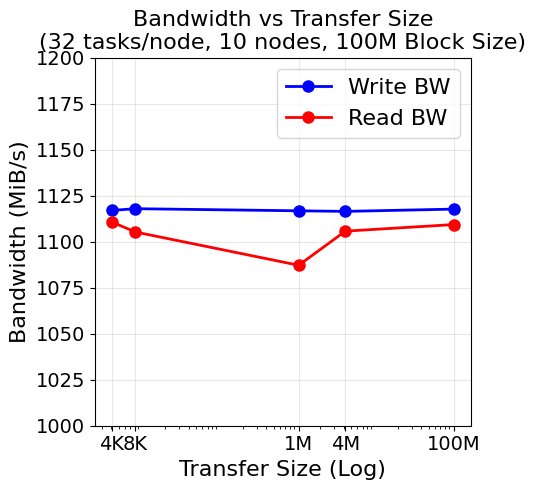


Summary of processed data:
Transfer Size Write BW (MiB/s) Read BW (MiB/s)
---------------------------------------------
4k           1117.0          1110.6         
8k           1117.9          1105.2         
1m           1116.7          1087.2         
4m           1116.4          1105.7         
100m         1117.7          1109.3         

Transfer size range: 4K to 100M
Write BW range: 1116.4 to 1117.9 MiB/s
Read BW range: 1087.2 to 1110.6 MiB/s


In [6]:
import os
import json
import matplotlib.pyplot as plt
import re
from collections import defaultdict

# Constants
TASKS_PER_NODE = 32
NUM_NODES = 10

def parse_size(size_str):
    """Parse size string and return size in bytes"""
    # Extract number and unit from strings like '100m', '4k', '1m'
    match = re.match(r'(\d+)([kmgt]?)', size_str.lower())
    if not match:
        return 0
    
    number = int(match.group(1))
    unit = match.group(2)
    
    multipliers = {
        '': 1,
        'k': 1024,
        'm': 1024**2,
        'g': 1024**3,
        't': 1024**4
    }
    
    return number * multipliers.get(unit, 1)

def format_size(size_bytes):
    """Format size in bytes to human readable format"""
    if size_bytes >= 1024**2:
        return f"{size_bytes / (1024**2):.0f}M"
    elif size_bytes >= 1024:
        return f"{size_bytes / 1024:.0f}K"
    else:
        return f"{size_bytes}B"

def extract_transfer_size(filepath):
    """Extract transfer size from filepath"""
    # Extract from filename like '32_ts100m_bs100m_t1.json' 
    filename = os.path.basename(filepath)
    
    # Extract the transfer size after 'ts'
    match = re.search(r'_ts([0-9]+[kmgt]?)_', filename)
    if match:
        return match.group(1)
    
    return None

def extract_tasks_per_node(filepath):
    """Extract tasks per node from filepath"""
    # Extract from filename like '32_ts100m_bs100m_t1.json' 
    filename = os.path.basename(filepath)
    
    # Extract the number at the beginning of filename
    match = re.search(r'^(\d+)_ts', filename)
    if match:
        return int(match.group(1))
    
    return None

def load_and_process_data():
    """Load specific JSON files and process the data for 32 tasks per node"""
    data = defaultdict(list)  # data[transfer_size] = [(write_bw, read_bw), ...]
    
    # Search in the specific directory structure
    base_dir = '10n_gateway_results_100bs'
    if not os.path.exists(base_dir):
        print(f"Directory {base_dir} not found in current path")
        return data
    
    # Find all JSON files for 32 tasks per node
    json_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.json') and file.startswith('32_ts') and '_bs100m_' in file:
                json_files.append(os.path.join(root, file))
    
    print(f"Found {len(json_files)} files for 32 tasks per node")
    
    for json_file in json_files:
        tasks_per_node = extract_tasks_per_node(json_file)
        transfer_size = extract_transfer_size(json_file)
        
        if tasks_per_node != TASKS_PER_NODE:
            continue  # Skip if not 32 tasks per node
            
        if transfer_size is None:
            print(f"Could not extract transfer size from: {json_file}")
            continue
        
        try:
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                
            if 'summary' not in json_data:
                print(f"No summary found in: {json_file}")
                continue
                
            write_bw = None
            read_bw = None
            
            for entry in json_data['summary']:
                if entry.get('operation') == 'write':
                    write_bw = entry.get('bwMeanMIB')
                elif entry.get('operation') == 'read':
                    read_bw = entry.get('bwMeanMIB')
            
            if write_bw is not None or read_bw is not None:
                data[transfer_size].append((write_bw, read_bw))
                print(f"Processed: {json_file} -> transfer_size:{transfer_size}, write:{write_bw}, read:{read_bw}")
                
        except Exception as e:
            print(f"Error processing {json_file}: {e}")
    
    return data

def average_data(data):
    """Average the bandwidth values for each transfer size configuration"""
    averaged_data = {}
    
    for transfer_size, bw_list in data.items():
        write_bws = [bw[0] for bw in bw_list if bw[0] is not None]
        read_bws = [bw[1] for bw in bw_list if bw[1] is not None]
        
        avg_write_bw = sum(write_bws) / len(write_bws) if write_bws else None
        avg_read_bw = sum(read_bws) / len(read_bws) if read_bws else None
        
        if avg_write_bw is not None or avg_read_bw is not None:
            averaged_data[transfer_size] = (avg_write_bw, avg_read_bw)
    
    return averaged_data

# Load and process all data
print(f"Loading and processing data for {TASKS_PER_NODE} tasks per node...")
all_data = load_and_process_data()

print(f"\nFound data for {len(all_data)} different transfer sizes:")
for ts in sorted(all_data.keys(), key=lambda x: parse_size(x)):
    print(f"  Transfer size: {ts}")

# Average the data across trials (t1, t2, t3)
averaged_data = average_data(all_data)

# Prepare data for plotting
plot_data = []
for transfer_size, (write_bw, read_bw) in averaged_data.items():
    transfer_size_bytes = parse_size(transfer_size)
    plot_data.append({
        'transfer_size': transfer_size,
        'transfer_size_bytes': transfer_size_bytes,
        'transfer_size_formatted': format_size(transfer_size_bytes),
        'write_bw': write_bw if write_bw is not None else 0,
        'read_bw': read_bw if read_bw is not None else 0
    })

# Sort by transfer size in bytes
plot_data.sort(key=lambda x: x['transfer_size_bytes'])

print(f"\nPlot data points: {len(plot_data)}")

if not plot_data:
    print("No data points found! Check file paths and data extraction.")
else:
    # Extract data for plotting
    transfer_sizes = [d['transfer_size_formatted'] for d in plot_data]
    transfer_size_bytes = [d['transfer_size_bytes'] for d in plot_data]
    write_bws = [d['write_bw'] for d in plot_data]
    read_bws = [d['read_bw'] for d in plot_data]

    # Create the plot
    plt.figure(figsize=(5, 5))
    
    # Use transfer size bytes for x-axis to enable log scale
    plt.plot(transfer_size_bytes, write_bws, 'bo-', label='Write BW', linewidth=2, markersize=8)
    plt.plot(transfer_size_bytes, read_bws, 'ro-', label='Read BW', linewidth=2, markersize=8)

    # Set log scale for x-axis since transfer sizes vary greatly
    plt.xscale('log')
    
    plt.xlabel('Transfer Size (Log)', fontsize=16)
    plt.ylabel('Bandwidth (MiB/s)', fontsize=16)
    plt.title(f'Bandwidth vs Transfer Size\n({TASKS_PER_NODE} tasks/node, {NUM_NODES} nodes, 100M Block Size)', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=16)

    # Set custom x-axis labels
    plt.xticks(transfer_size_bytes, transfer_sizes, fontsize=14)
    plt.yticks(fontsize=14)
    
    # Optional: Set y-axis to start from 0 for better comparison
    plt.ylim(bottom=1000,top=1200)

    # # Add text annotations showing actual transfer sizes
    # for d in plot_data:
    #     max_bw = max(d['write_bw'], d['read_bw'])
    #     plt.annotate(d['transfer_size'], 
    #                 xy=(d['transfer_size_bytes'], max_bw), 
    #                 xytext=(0, 10), textcoords='offset points', 
    #                 fontsize=8, ha='center')

    plt.tight_layout()
    # plt.savefig(f'bandwidth_vs_transfer_size_{TASKS_PER_NODE}tpn.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'ior_transfer_size.pdf', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary
    print("\nSummary of processed data:")
    print(f"{'Transfer Size':<12} {'Write BW (MiB/s)':<15} {'Read BW (MiB/s)':<15}")
    print("-" * 45)
    for d in plot_data:
        print(f"{d['transfer_size']:<12} {d['write_bw']:<15.1f} {d['read_bw']:<15.1f}")
        
    # Additional analysis
    print(f"\nTransfer size range: {transfer_sizes[0]} to {transfer_sizes[-1]}")
    print(f"Write BW range: {min(write_bws):.1f} to {max(write_bws):.1f} MiB/s")
    print(f"Read BW range: {min(read_bws):.1f} to {max(read_bws):.1f} MiB/s")